In [1]:
!pip install pyro-ppl

In [2]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from torch import nn

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

# Quick review of Pyro and VI

Recap: Pyro model has 

- observations ⟺ pyro.sample with the obs argument
- latent random variables ⟺ pyro.sample
- parameters ⟺ pyro.param

### Latent Variable Models

p<sub>θ</sub>(x,z)=p<sub>θ</sub>(x|z)p<sub>θ</sub>(z)

x = observations, z = latent variables, θ = parameters

Assume that the p<sub>i</sub> which make up P<sub>θ</sub>(x,z) have following properties:

- can sample from each p<sub>i</sub>
- can compute pointwise log pdf p<sub>i</sub>
- p<sub>i</sub> is differentiable wrt θ

## Learning 

We want to maximize the log-evidence of the mode: 

θ <sub>max</sub> = argmax <sub>θ</sub> logp <sub>θ</sub>(x)

And calculate the posterior over z:

p<sub>θ<sub>max</sub></sub>(z|x)=p<sub>θ<sub>max</sub></sub>(x,z) / ∫dzp<sub>θ<sub>max</sub></sub>(x,z)

## ELBO

parameterized distribution q<sub>ϕ</sub>(z) = variational distribution  

The model evidence is lower bounded by the ELBO (see slides)  

logp<sub>θ</sub>(x) ≥ ELBO  

where  

ELBO = E<sub>q<sub>ϕ</sub></sub>(z){logp<sub>θ</sub>(x,z)−logq<sub>ϕ</sub>(z)}

## A Bayesian regression example

In [3]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

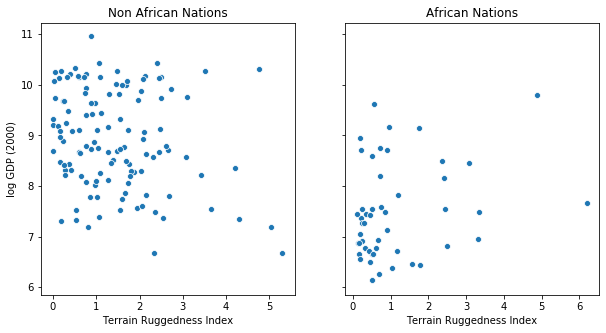

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [11]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

Data models topographic heterogenity vs GDP per capita -> transformed to log(GDP)

### Bayesian regression

Linear regression: Y = Wx + b  
For Bayesian linear regression we define priors over W and b and learn a distribution over both

In [5]:
from pyro.nn import PyroModule, PyroSample

In [6]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

A couple of things:

- The ```pyro.plate()``` construct: It is very similar to range and used for looping over observations with one key difference: **Conditional Independence**. When we intitalize the observations inside the ```plate``` primitive  it tells Pyro that our observations are conditionally independent given the variables outside the context of plate (the latent variables sigma and mean here since they are being sample outside the context of "data").  


- ```PyroModule``` is very similar to ```nn.Module``` in Pytorch (the base class for all neural net modules) and basically needs an \__init__() and a forward() method. So ```PyroModule[nn.Linear]``` is just a linear regression model. However it additionally supports Pyro primitives like sample, plate etc


- Learnable parameters when declared inside ```PyroModule``` are automatically registered in Pyro's param store (no need to separately call param).  
 

- The ```BayesianRegression.forward()``` method specifies the generative process. We first generate the mean value of response (i.e. log(GDP)) by calling the linear module which samples weight and bias from the prior and returns a mean response. Then we use obs argument in pyro.sample to condition on the observed data y with a learned observation noise sigma.

### Variational Inference made easy: the AutoGuide

One key choice in variational inference is the choice of the family of posteriors to approximate the true posterior. This variational distribution (or guide in Pyro's terms) is what determines our ELBO term. 

Pyro provides a suite of simple guides that can be used for modelling via the ```AutoGuide``` library. These may not be suitable for complex problems but for something like linear regression they come in very handy. 

In [7]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

```AutoDiagonalNormal``` guide models the distribution as a Gaussian with diagonal covariance i.e. it **assumes that there is no correlation amongst the latent variables** (also called the Mean Field approximation in variational inference). It defines Normal distributions with learnable parameters for each of the sample statements in the model - 3 regression coefficients, 1 intercept component, 1 component for sigma in the model 

### Optimizing the ELBO

In [8]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [12]:
pyro.clear_param_store()
num_iterations = 1500

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 3.5248
[iteration 0101] loss: 2.2142
[iteration 0201] loss: 1.6068
[iteration 0301] loss: 1.4603
[iteration 0401] loss: 1.4656
[iteration 0501] loss: 1.4627
[iteration 0601] loss: 1.4758
[iteration 0701] loss: 1.4514
[iteration 0801] loss: 1.4389
[iteration 0901] loss: 1.4630
[iteration 1001] loss: 1.4596
[iteration 1101] loss: 1.4603
[iteration 1201] loss: 1.4873
[iteration 1301] loss: 1.4611
[iteration 1401] loss: 1.4747


In [13]:
# Now if we check the parameters they have an uncertainity estimate as well

guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2531, -1.8341, -0.1589,  0.3406,  9.1957])
AutoDiagonalNormal.scale tensor([0.0690, 0.1257, 0.0342, 0.0862, 0.0726])


### Visualizations 

In [14]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [15]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

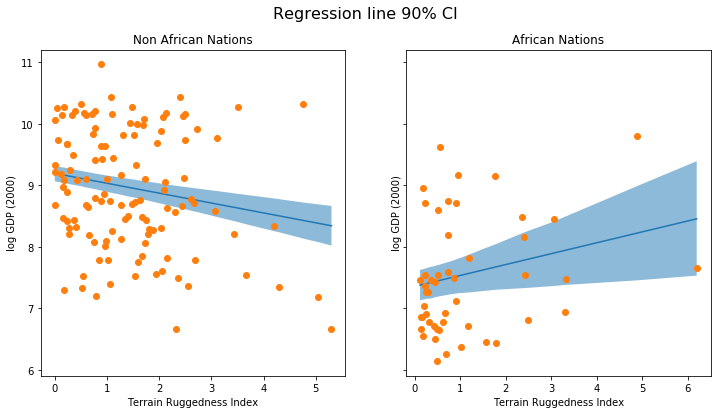

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

Most points are actually missed by simply taking the 90% CI around the mean learned by our SVI.  
Instead it would make more sense to plot the 90% CI around the outcome variable since it is affected by the learned sigma.

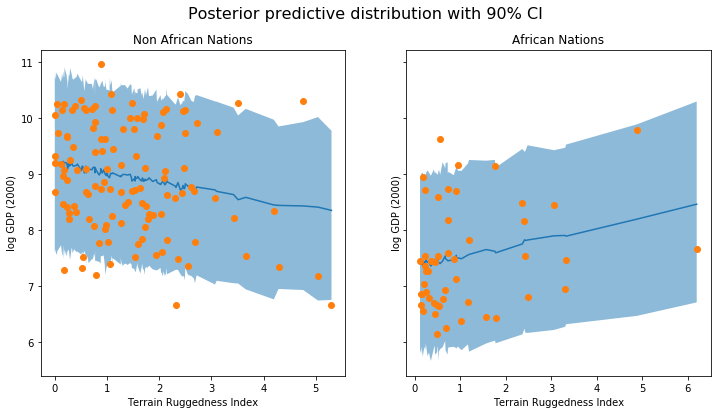

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");